# Chapter 6 학습 관련 기술들

## 6.1 매개변수 갱신

### 6.1.2 확률적 경사 하강법(SGD)
$W ⬅ W - \eta\frac{\partial L}{\partial W} $

In [1]:
# 구현
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            

SGD의 단점은 비등방성함수에서는 탐색 경로가 비효율적이라는것.<br/>
이를 개선한게 모멘텀, AdaGrad, Adam

### 6.1.4 모멘텀
$v ⬅ \alpha v - \eta\frac{\partial L}{\partial W} $ <br/>
$W ⬅ W + v $

In [ ]:
# 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]
            

### 6.1.5 AdaGrad
$h ⬅ h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W} $<br/>
$W ⬅ W - \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W} $
* 각각의 매개변수에 적응적으로 '학습률'을 조정하면서 학습을 진행


In [3]:
# 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam
* 모멘텀과 AdaGGrad를 융합한 듯한 방법
* 하이퍼파라미터의 '편향 보정'

In [ ]:
# 구현
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### RMSprop
* AdaGrad에서 과거 값을 점점 잊어가면서 갱신
* 이를 지수이동평균이라 하며, 과거 기울기의 반영 규모를 기하급수적으로 감소시킴

In [ ]:
# 구현
class RMSprop:
    def __init__(self, lr =0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.7 갱신 방법 비교

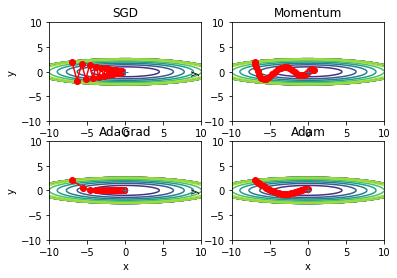

In [13]:
import sys, os
path = '/content/drive/MyDrive/DL_from_bottom'
os.chdir(path)
sys.path.append(os.chdir)

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *
from common.layers import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

In [14]:
class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

===========iteration:0============
SGD:2.3618970622643145
Momentum:2.403741644233034
AdaGrad:1.9869183202280585
Adam:2.1611698109533215
RMSprop:14.851615340766354
===========iteration:100============
SGD:1.6219808582492292
Momentum:0.34521086999827244
AdaGrad:0.15014084309089593
Adam:0.2962318716111155
RMSprop:0.4417315904122495
===========iteration:200============
SGD:0.8141830701055317
Momentum:0.23725787706708423
AdaGrad:0.06315661539754328
Adam:0.15460868131937439
RMSprop:0.1842022732699392
===========iteration:300============
SGD:0.497933792957213
Momentum:0.16554084266061014
AdaGrad:0.06161264366498401
Adam:0.11573218529930099
RMSprop:0.08314059573837379
===========iteration:400============
SGD:0.4504375358145778
Momentum:0.18953408428548638
AdaGrad:0.1132711585211304
Adam:0.18101578741440433
RMSprop:0.1763301613583668
===========iteration:500============
SGD:0.37208566175257085
Momentum:0.12565756537682013
AdaGrad:0.07499303417020682
Adam:0.07145785064401892
RMSprop:0.1021052325

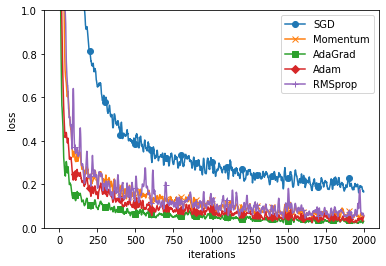

In [16]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
# from.multi_layer_net import MultiLayerNet

# MNIST 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)  # 원핫 인코딩 안함

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 실험용 설정
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []

# 훈련
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "============")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 그래프 그리기
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "+"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


SGD를 제외한 나머지는 비슷한 결과를 보여줌.<br/>
하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라질 수 있다.

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면
* 가중치를 모두 같은 값으로 두면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신됨.
* 따라서 초깃값을 무작위로 설정할 필요가 있음.

### 6.2.2 은닉층의 활성화값 분포
* 가중치의 초깃값에 따라 은닉층 활성화값들이 어떻게 변화하는지 관찰
* 시그모이드 함수를 사용하는 5층 신경망을 통해 시험할 예정

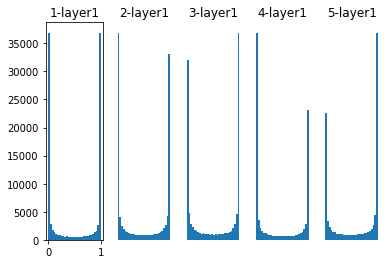

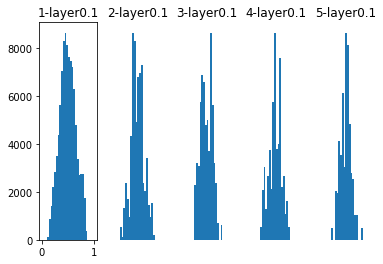

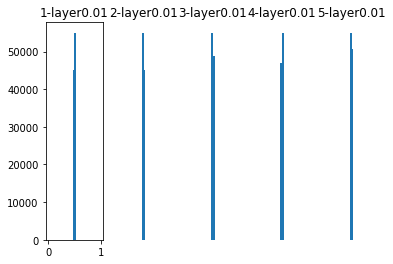

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5           # 은닉층 5개
activations = {}                # 활성화값 저장

for r in [1, 0.1, 0.01]:
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num, node_num) * r

        a = np.dot(x, w)
        z = sigmoid(a)
        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer" + str(r))
        plt.hist(a.flatten(), 30, range=(0,1))

        if i != 0:
            plt.axis('off')
    plt.show()

위 첫번째 히스토그램을 보면 기울기 소실 문제를 관찰할 수 있음.(gradient vanishing) <br/>
세번째 히스토그램을 보면 활성화값들이 치우치면서 표현력을 제한하는 문제 발생

Xavier 초깃값 활용
* 앞 계층의 노드가 n개면 표준편차가 $\frac{1}{\sqrt n}$인 분포를 사용
* 실제 사비에르의 논문에서는 다음 층의 노드 수도 고려했지만, 카페 등의 프레임워크는 앞 층의 입력 노드만으로 계산하도록 단순화함

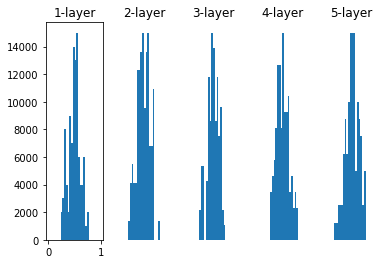

In [35]:

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

    if i != 0:
            plt.axis('off')
            
plt.show()

tanh 함수를 사용하면 좀 더 개선됨

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값
* Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과.
* Sigmoid와 tanh 함수는 중앙 부근이 선형인 함수로 볼 수 있음.
* ReLu는 He 초깃값을 사용함.<br/>
표준편차가 $\sqrt \frac{2}{n}$인 정규분포 사용

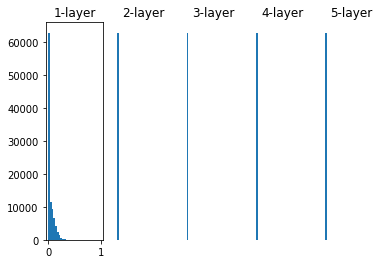

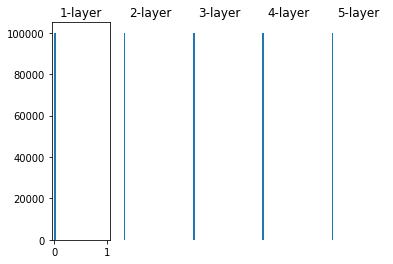

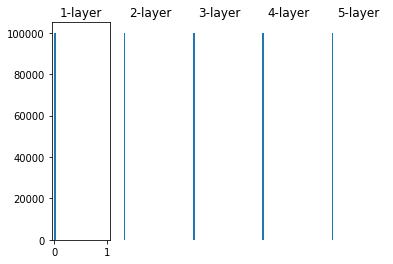

In [43]:
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100) 
node_num = 100                 
hidden_layer_size = 5          
activations = {}               

for r in [0.01, 1/np.sqrt(node_num), np.sqrt(2/node_num)]:
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num, node_num) * r

        a = np.dot(x, w)
        z = relu(a)
        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        plt.hist(a.flatten(), 30, range=(0,1))

        if i != 0:
            plt.axis('off')
    plt.show()


히스토그램에 결과가 제대로 안나온것 같지만 책을 기준으로 적자면 
* std=0.01일 때는 각 층의 활성화값들이 아주 작은 값들임. 즉, 역전파 때 가중치의 기울기 역시 작아진다는 뜻. 결과로 학습이 거의 이뤄지지 않을 것.
* std=Xavier일땐 층이 깊어짐에 따라 치우침이 커짐. 그에 따라 활성화값들의 치우침도 커지고, 학습할 때 기울기 소실 문제를 일으킴
* std=He일땐 모든 층에서 균일하게 분포

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

============iteration:0============
std=0.01:2.302544807445582
Xavier:2.3083866291511708
He:2.400564048914842
============iteration:100============
std=0.01:2.301519839669495
Xavier:2.2698579818198876
He:1.472899324343452
============iteration:200============
std=0.01:2.301561800561429
Xavier:2.202268279658798
He:0.689866763391041
============iteration:300============
std=0.01:2.3034967548758036
Xavier:2.0932289536861988
He:0.5864090601355005
============iteration:400============
std=0.01:2.299945460310303
Xavier:1.7162761868851575
He:0.42491053820392444
============iteration:500============
std=0.01:2.300513158261463
Xavier:1.2804489044320766
He:0.3662891219987622
============iteration:600============
std=0.01:2.299904801699255
Xavier:0.8676791184253001
He:0.3105421071798911
============iteration:700============
std=0.01:2.3045997978476773
Xavier:0.8305383783113076
He:0.39228616277534856
============iteration:800============
std=0.01:2.2987824189006743
Xavier:0.495179022779617
He:0.24

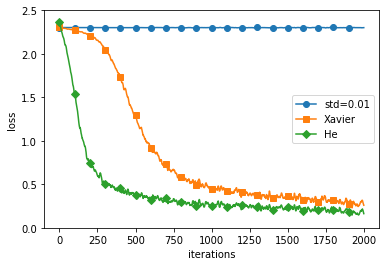

In [46]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 실험용 설정
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 훈련
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("============" + "iteration:" + str(i) + "============")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 그래프 그리기
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

앞에서 관찰한 것과 같이 std=0.01일때는 학습이 전혀 이루어지지 않았음.

## 6.3 배치 정규화
* 각 층의 황성화를 적당히 퍼뜨리도록 '강제'하는 방법
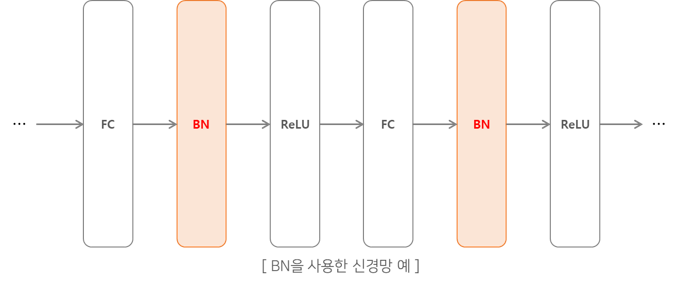

[관련 논문](https://arxiv.org/pdf/1502.03167v3.pdf)

* 배치 정규화는 미니배치를 단위로 정규화함.
* 정확히는 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화
* 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동변환을 수행

### 6.3.2 배치 정규화의 효과

============1/16=============
epoch:0 | 0.093 - 0.101


/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.092 - 0.13
epoch:2 | 0.116 - 0.161
epoch:3 | 0.116 - 0.187
epoch:4 | 0.116 - 0.206
epoch:5 | 0.117 - 0.237
epoch:6 | 0.116 - 0.251
epoch:7 | 0.116 - 0.262
epoch:8 | 0.117 - 0.275
epoch:9 | 0.117 - 0.288
epoch:10 | 0.117 - 0.303
epoch:11 | 0.117 - 0.324
epoch:12 | 0.117 - 0.34
epoch:13 | 0.117 - 0.352
epoch:14 | 0.117 - 0.36
epoch:15 | 0.117 - 0.375
epoch:16 | 0.117 - 0.382
epoch:17 | 0.117 - 0.383
epoch:18 | 0.117 - 0.398


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.42
============2/16=============
epoch:0 | 0.099 - 0.103


/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/DL_from_bottom/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.112
epoch:2 | 0.097 - 0.111
epoch:3 | 0.097 - 0.139
epoch:4 | 0.097 - 0.162
epoch:5 | 0.097 - 0.197
epoch:6 | 0.097 - 0.22
epoch:7 | 0.097 - 0.243
epoch:8 | 0.097 - 0.265
epoch:9 | 0.097 - 0.287
epoch:10 | 0.097 - 0.306
epoch:11 | 0.097 - 0.336
epoch:12 | 0.097 - 0.363
epoch:13 | 0.097 - 0.371
epoch:14 | 0.097 - 0.384
epoch:15 | 0.097 - 0.409
epoch:16 | 0.097 - 0.434
epoch:17 | 0.097 - 0.436
epoch:18 | 0.097 - 0.452


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.472
============3/16=============
epoch:0 | 0.098 - 0.135
epoch:1 | 0.41 - 0.141
epoch:2 | 0.559 - 0.156
epoch:3 | 0.635 - 0.189
epoch:4 | 0.71 - 0.219
epoch:5 | 0.764 - 0.267
epoch:6 | 0.811 - 0.296
epoch:7 | 0.858 - 0.328
epoch:8 | 0.874 - 0.37
epoch:9 | 0.924 - 0.404
epoch:10 | 0.939 - 0.444
epoch:11 | 0.951 - 0.472
epoch:12 | 0.956 - 0.505
epoch:13 | 0.969 - 0.528
epoch:14 | 0.975 - 0.556
epoch:15 | 0.979 - 0.574
epoch:16 | 0.984 - 0.587
epoch:17 | 0.987 - 0.612
epoch:18 | 0.991 - 0.637


No handles with labels found to put in legend.


epoch:19 | 0.995 - 0.656
============4/16=============
epoch:0 | 0.145 - 0.101
epoch:1 | 0.333 - 0.101
epoch:2 | 0.471 - 0.166
epoch:3 | 0.554 - 0.249
epoch:4 | 0.634 - 0.322
epoch:5 | 0.684 - 0.377
epoch:6 | 0.704 - 0.429
epoch:7 | 0.724 - 0.481
epoch:8 | 0.762 - 0.516
epoch:9 | 0.783 - 0.558
epoch:10 | 0.804 - 0.594
epoch:11 | 0.811 - 0.618
epoch:12 | 0.833 - 0.638
epoch:13 | 0.836 - 0.672
epoch:14 | 0.856 - 0.685
epoch:15 | 0.857 - 0.703
epoch:16 | 0.848 - 0.717
epoch:17 | 0.875 - 0.741
epoch:18 | 0.869 - 0.759


No handles with labels found to put in legend.


epoch:19 | 0.877 - 0.774
============5/16=============
epoch:0 | 0.086 - 0.123
epoch:1 | 0.093 - 0.173
epoch:2 | 0.095 - 0.319
epoch:3 | 0.101 - 0.454
epoch:4 | 0.102 - 0.534
epoch:5 | 0.113 - 0.592
epoch:6 | 0.113 - 0.63
epoch:7 | 0.128 - 0.662
epoch:8 | 0.139 - 0.688
epoch:9 | 0.158 - 0.714
epoch:10 | 0.175 - 0.735
epoch:11 | 0.191 - 0.755
epoch:12 | 0.205 - 0.77
epoch:13 | 0.211 - 0.793
epoch:14 | 0.213 - 0.8
epoch:15 | 0.224 - 0.811
epoch:16 | 0.225 - 0.821
epoch:17 | 0.239 - 0.831
epoch:18 | 0.247 - 0.845


No handles with labels found to put in legend.


epoch:19 | 0.268 - 0.853
============6/16=============
epoch:0 | 0.124 - 0.108
epoch:1 | 0.108 - 0.223
epoch:2 | 0.11 - 0.467
epoch:3 | 0.12 - 0.615
epoch:4 | 0.116 - 0.684
epoch:5 | 0.143 - 0.741
epoch:6 | 0.116 - 0.778
epoch:7 | 0.165 - 0.806
epoch:8 | 0.124 - 0.82
epoch:9 | 0.152 - 0.838
epoch:10 | 0.144 - 0.846
epoch:11 | 0.119 - 0.871
epoch:12 | 0.133 - 0.883
epoch:13 | 0.122 - 0.902
epoch:14 | 0.117 - 0.91
epoch:15 | 0.117 - 0.913
epoch:16 | 0.117 - 0.933
epoch:17 | 0.117 - 0.941
epoch:18 | 0.117 - 0.944


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.947
============7/16=============
epoch:0 | 0.099 - 0.134
epoch:1 | 0.116 - 0.316
epoch:2 | 0.116 - 0.515
epoch:3 | 0.116 - 0.683
epoch:4 | 0.198 - 0.742
epoch:5 | 0.116 - 0.764
epoch:6 | 0.117 - 0.798
epoch:7 | 0.117 - 0.814
epoch:8 | 0.117 - 0.843
epoch:9 | 0.117 - 0.873
epoch:10 | 0.117 - 0.891
epoch:11 | 0.117 - 0.906
epoch:12 | 0.117 - 0.929
epoch:13 | 0.117 - 0.944
epoch:14 | 0.117 - 0.957
epoch:15 | 0.117 - 0.968
epoch:16 | 0.117 - 0.971
epoch:17 | 0.117 - 0.977
epoch:18 | 0.117 - 0.985


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.986
============8/16=============
epoch:0 | 0.092 - 0.095
epoch:1 | 0.097 - 0.435
epoch:2 | 0.099 - 0.685
epoch:3 | 0.116 - 0.781
epoch:4 | 0.116 - 0.871
epoch:5 | 0.116 - 0.905
epoch:6 | 0.116 - 0.94
epoch:7 | 0.116 - 0.955
epoch:8 | 0.116 - 0.973
epoch:9 | 0.116 - 0.981
epoch:10 | 0.116 - 0.983
epoch:11 | 0.116 - 0.989
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.999
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============9/16=============
epoch:0 | 0.099 - 0.162
epoch:1 | 0.116 - 0.456
epoch:2 | 0.116 - 0.702
epoch:3 | 0.116 - 0.753
epoch:4 | 0.116 - 0.777
epoch:5 | 0.116 - 0.821
epoch:6 | 0.116 - 0.867
epoch:7 | 0.116 - 0.928
epoch:8 | 0.116 - 0.956
epoch:9 | 0.116 - 0.982
epoch:10 | 0.116 - 0.989
epoch:11 | 0.116 - 0.994
epoch:12 | 0.116 - 0.999
epoch:13 | 0.116 - 0.999
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.999
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============10/16=============
epoch:0 | 0.105 - 0.129
epoch:1 | 0.099 - 0.537
epoch:2 | 0.117 - 0.792
epoch:3 | 0.117 - 0.837
epoch:4 | 0.117 - 0.909
epoch:5 | 0.117 - 0.864
epoch:6 | 0.117 - 0.968
epoch:7 | 0.116 - 0.974
epoch:8 | 0.116 - 0.988
epoch:9 | 0.116 - 0.985
epoch:10 | 0.117 - 0.985
epoch:11 | 0.117 - 0.993
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.997
epoch:15 | 0.116 - 0.998
epoch:16 | 0.117 - 0.997
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============11/16=============
epoch:0 | 0.094 - 0.157
epoch:1 | 0.117 - 0.574
epoch:2 | 0.117 - 0.751
epoch:3 | 0.117 - 0.726
epoch:4 | 0.116 - 0.766
epoch:5 | 0.116 - 0.763
epoch:6 | 0.116 - 0.825
epoch:7 | 0.116 - 0.861
epoch:8 | 0.116 - 0.878
epoch:9 | 0.116 - 0.894
epoch:10 | 0.116 - 0.889
epoch:11 | 0.116 - 0.834
epoch:12 | 0.116 - 0.873
epoch:13 | 0.116 - 0.892
epoch:14 | 0.116 - 0.904
epoch:15 | 0.116 - 0.901
epoch:16 | 0.116 - 0.904
epoch:17 | 0.116 - 0.902
epoch:18 | 0.116 - 0.908


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.899
============12/16=============
epoch:0 | 0.097 - 0.129
epoch:1 | 0.116 - 0.491
epoch:2 | 0.117 - 0.712
epoch:3 | 0.117 - 0.714
epoch:4 | 0.116 - 0.696
epoch:5 | 0.116 - 0.676
epoch:6 | 0.117 - 0.785
epoch:7 | 0.117 - 0.863
epoch:8 | 0.117 - 0.804
epoch:9 | 0.117 - 0.83
epoch:10 | 0.117 - 0.875
epoch:11 | 0.117 - 0.857
epoch:12 | 0.117 - 0.889
epoch:13 | 0.117 - 0.872
epoch:14 | 0.117 - 0.901
epoch:15 | 0.117 - 0.9
epoch:16 | 0.117 - 0.902
epoch:17 | 0.117 - 0.864
epoch:18 | 0.117 - 0.905


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.906
============13/16=============
epoch:0 | 0.116 - 0.197
epoch:1 | 0.117 - 0.405
epoch:2 | 0.117 - 0.484
epoch:3 | 0.117 - 0.496
epoch:4 | 0.117 - 0.418
epoch:5 | 0.116 - 0.503
epoch:6 | 0.116 - 0.517
epoch:7 | 0.116 - 0.503
epoch:8 | 0.116 - 0.529
epoch:9 | 0.116 - 0.571
epoch:10 | 0.116 - 0.58
epoch:11 | 0.116 - 0.578
epoch:12 | 0.116 - 0.598
epoch:13 | 0.116 - 0.591
epoch:14 | 0.116 - 0.608
epoch:15 | 0.116 - 0.602
epoch:16 | 0.116 - 0.61
epoch:17 | 0.116 - 0.612
epoch:18 | 0.116 - 0.593


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.6
============14/16=============
epoch:0 | 0.117 - 0.109
epoch:1 | 0.117 - 0.399
epoch:2 | 0.117 - 0.453
epoch:3 | 0.117 - 0.583
epoch:4 | 0.117 - 0.578
epoch:5 | 0.117 - 0.58
epoch:6 | 0.117 - 0.598
epoch:7 | 0.117 - 0.571
epoch:8 | 0.117 - 0.6
epoch:9 | 0.117 - 0.616
epoch:10 | 0.117 - 0.62
epoch:11 | 0.117 - 0.621
epoch:12 | 0.117 - 0.614
epoch:13 | 0.117 - 0.621
epoch:14 | 0.117 - 0.631
epoch:15 | 0.117 - 0.623
epoch:16 | 0.117 - 0.625
epoch:17 | 0.117 - 0.737
epoch:18 | 0.117 - 0.753


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.727
============15/16=============
epoch:0 | 0.093 - 0.115
epoch:1 | 0.116 - 0.257
epoch:2 | 0.116 - 0.38
epoch:3 | 0.116 - 0.346
epoch:4 | 0.116 - 0.387
epoch:5 | 0.116 - 0.352
epoch:6 | 0.116 - 0.407
epoch:7 | 0.116 - 0.352
epoch:8 | 0.117 - 0.417
epoch:9 | 0.117 - 0.415
epoch:10 | 0.117 - 0.402
epoch:11 | 0.117 - 0.415
epoch:12 | 0.116 - 0.421
epoch:13 | 0.116 - 0.418
epoch:14 | 0.116 - 0.42
epoch:15 | 0.116 - 0.421
epoch:16 | 0.116 - 0.423
epoch:17 | 0.117 - 0.433
epoch:18 | 0.116 - 0.443


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.422
============16/16=============
epoch:0 | 0.105 - 0.219
epoch:1 | 0.117 - 0.217
epoch:2 | 0.117 - 0.308
epoch:3 | 0.117 - 0.373
epoch:4 | 0.116 - 0.413
epoch:5 | 0.116 - 0.393
epoch:6 | 0.116 - 0.402
epoch:7 | 0.116 - 0.41
epoch:8 | 0.116 - 0.415
epoch:9 | 0.117 - 0.421
epoch:10 | 0.116 - 0.424
epoch:11 | 0.116 - 0.427
epoch:12 | 0.116 - 0.427
epoch:13 | 0.117 - 0.427
epoch:14 | 0.116 - 0.413
epoch:15 | 0.116 - 0.423
epoch:16 | 0.116 - 0.428
epoch:17 | 0.117 - 0.427
epoch:18 | 0.116 - 0.426
epoch:19 | 0.116 - 0.428


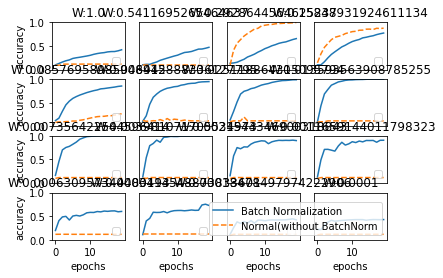

In [48]:
from ch06.batch_norm_test import __train

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터 축소
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

# 그래프 그리기
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("============" + str(i+1) + "/16" + "=============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--",markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

거의 모든 경우에서 배치 정규화 사용시에 학습 진도가 빠른 것으로 나타남.<br/>
실제로 배치 정규화를 이용하지 않을 시에는 초깃값 분포가잘 되어 있지 않으면 학습이 전혀 진행되지 않음.<br/>
배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 됨.